<a href="https://colab.research.google.com/github/Harshraj-pixel/Vehicle-detection-in-foggy-weather-/blob/main/Copy_of_FINAL_MODEL1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics opencv-python albumentations --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.6 MB/s eta 0:00:00


In [ ]:
# Download KITTI images and labels
!wget -q https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_image_2.zip
!wget -q https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_label_2.zip

# Unzip into working directory
!unzip -q data_object_image_2.zip -d /content/
!unzip -q data_object_label_2.zip -d /content/

In [ ]:
import os

# Create YOLO label folders
os.makedirs("/content/kitti_yolo/images", exist_ok=True)
os.makedirs("/content/kitti_yolo/labels", exist_ok=True)

# Load label converter
def convert_kitti_to_yolo(kitti_label_folder, image_folder, output_image_dir, output_label_dir):
    from PIL import Image

    files = os.listdir(kitti_label_folder)
    for file in files:
        img_id = file.replace(".txt", "")
        img_path = os.path.join(image_folder, f"{img_id}.png")
        if not os.path.exists(img_path):
            continue

        im = Image.open(img_path)
        W, H = im.size
        in_file = open(os.path.join(kitti_label_folder, file))
        out_file = open(os.path.join(output_label_dir, file), 'w')

        for line in in_file:
            parts = line.strip().split(" ")
            cls = parts[0]
            if cls not in ['Car', 'Pedestrian', 'Cyclist']:
                continue
            cls_id = {'Car': 0, 'Pedestrian': 1, 'Cyclist': 2}[cls]
            bbox = list(map(float, parts[4:8]))
            x_center = ((bbox[0] + bbox[2]) / 2.0) / W
            y_center = ((bbox[1] + bbox[3]) / 2.0) / H
            width = (bbox[2] - bbox[0]) / W
            height = (bbox[3] - bbox[1]) / H
            out_file.write(f"{cls_id} {x_center} {y_center} {width} {height}\n")

        in_file.close()
        out_file.close()

        # Copy image to YOLO image folder
        os.system(f"cp {img_path} {os.path.join(output_image_dir, os.path.basename(img_path))}")

# Run conversion
convert_kitti_to_yolo(
    kitti_label_folder="/content/training/label_2",
    image_folder="/content/training/image_2",
    output_image_dir="/content/kitti_yolo/images",
    output_label_dir="/content/kitti_yolo/labels"
)


In [ ]:
import cv2

def apply_clahe(src_dir, dst_dir):
    os.makedirs(dst_dir, exist_ok=True)
    for file in os.listdir(src_dir):
        img_path = os.path.join(src_dir, file)
        img = cv2.imread(img_path)
        if img is None:
            continue
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        cl = clahe.apply(l)
        merged = cv2.merge((cl, a, b))
        final = cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)
        cv2.imwrite(os.path.join(dst_dir, file), final)

apply_clahe("/content/kitti_yolo/images", "/content/kitti_yolo/images_clahe")


In [ ]:
from sklearn.model_selection import train_test_split
import shutil

# Split into train/val
image_files = os.listdir("/content/kitti_yolo/images_clahe")
train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

# Prepare folders
for split in ['train', 'val']:
    os.makedirs(f"/content/kitti_yolo/images/{split}", exist_ok=True)
    os.makedirs(f"/content/kitti_yolo/labels/{split}", exist_ok=True)

# Move images and labels to proper folders
for file in train_files:
    shutil.copy(f"/content/kitti_yolo/images_clahe/{file}", f"/content/kitti_yolo/images/train/{file}")
    shutil.copy(f"/content/kitti_yolo/labels/{file.replace('.png', '.txt')}", f"/content/kitti_yolo/labels/train/{file.replace('.png', '.txt')}")

for file in val_files:
    shutil.copy(f"/content/kitti_yolo/images_clahe/{file}", f"/content/kitti_yolo/images/val/{file}")
    shutil.copy(f"/content/kitti_yolo/labels/{file.replace('.png', '.txt')}", f"/content/kitti_yolo/labels/val/{file.replace('.png', '.txt')}")


In [ ]:
# Create YAML file
yaml_text = """
path: /content/kitti_yolo
train: images/train
val: images/val

names:
  0: Car
  1: Pedestrian
  2: Cyclist
"""

with open("/content/kitti_yolo/kitti.yaml", "w") as f:
    f.write(yaml_text)


In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8l.pt")
model.train(
    data="/content/kitti_yolo/kitti.yaml",
    epochs=20,
    imgsz=640,
    batch=16,
    name="kitti_yolo_retry",
    patience=30
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 83.7M/83.7M [00:00<00:00, 394MB/s]


Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/kitti_yolo/kitti.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=kitti_yolo_retry, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=30, perspective=0.0, plots=True, pose=12.0

100%|██████████| 755k/755k [00:00<00:00, 115MB/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1  1   2360320  ultralytics

  9                  -1  1    656896  ultralytics.nn.modules.block.SPPF            [512, 512, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  3   4723712  ultralytics.nn.modules.block.C2f             [1024, 512, 3]                
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  3   1247744  ultralytics.nn.modules.block.C2f             [768, 256, 3]                 
 16                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
 17            [-1, 12]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

100%|██████████| 5.35M/5.35M [00:00<00:00, 328MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 298.1±434.1 MB/s, size: 922.3 KB)


train: Scanning /content/kitti_yolo/labels/train... 5984 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5984/5984 [00:35<00:00, 168.44it/s]


train: New cache created: /content/kitti_yolo/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 133.1±34.9 MB/s, size: 886.2 KB)


val: Scanning /content/kitti_yolo/labels/val... 1497 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1497/1497 [00:08<00:00, 166.67it/s]


val: New cache created: /content/kitti_yolo/labels/val.cache
Plotting labels to runs/detect/kitti_yolo_retry/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/kitti_yolo_retry
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      9.28G      1.179     0.9521      1.104        146        640: 100%|██████████| 374/374 [05:04<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:25<00:00,  1.83it/s]


                   all       1497       7148      0.613       0.54      0.581      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      9.95G      1.192     0.8233       1.12        129        640: 100%|██████████| 374/374 [05:01<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:24<00:00,  1.95it/s]

                   all       1497       7148      0.697      0.542      0.594      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      9.88G      1.164     0.7925      1.107        193        640: 100%|██████████| 374/374 [05:00<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:24<00:00,  1.89it/s]


                   all       1497       7148      0.732      0.592      0.662      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      9.99G       1.11     0.7335      1.079        193        640: 100%|██████████| 374/374 [04:59<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:24<00:00,  1.92it/s]

                   all       1497       7148      0.726      0.624      0.692      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      9.94G      1.058     0.6913      1.054        153        640: 100%|██████████| 374/374 [04:59<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:24<00:00,  1.91it/s]

                   all       1497       7148      0.748      0.631      0.709      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      9.89G      1.021     0.6514      1.036        151        640: 100%|██████████| 374/374 [04:59<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:24<00:00,  1.91it/s]

                   all       1497       7148      0.753      0.647      0.702      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      9.94G     0.9938     0.6281      1.025        125        640: 100%|██████████| 374/374 [04:59<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:24<00:00,  1.95it/s]

                   all       1497       7148      0.827      0.642      0.751      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      9.93G     0.9667      0.599      1.013        198        640: 100%|██████████| 374/374 [04:59<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:24<00:00,  1.90it/s]

                   all       1497       7148      0.801       0.68      0.766      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       9.9G     0.9399     0.5822     0.9989        105        640: 100%|██████████| 374/374 [04:59<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:24<00:00,  1.91it/s]

                   all       1497       7148      0.832      0.696      0.786      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      9.92G     0.9122     0.5591     0.9884        173        640: 100%|██████████| 374/374 [04:58<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:24<00:00,  1.91it/s]

                   all       1497       7148      0.799      0.718      0.799      0.509


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20       9.9G     0.9213     0.5564      0.996         72        640: 100%|██████████| 374/374 [04:58<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:24<00:00,  1.90it/s]

                   all       1497       7148       0.82      0.712      0.793      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      9.92G     0.9023     0.5417     0.9865         82        640: 100%|██████████| 374/374 [04:57<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:25<00:00,  1.88it/s]

                   all       1497       7148      0.833      0.711      0.797      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      9.94G     0.8731       0.52      0.975         74        640: 100%|██████████| 374/374 [04:57<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:25<00:00,  1.87it/s]

                   all       1497       7148      0.848      0.715      0.811      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      9.93G     0.8578     0.5057     0.9697         83        640: 100%|██████████| 374/374 [04:57<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:24<00:00,  1.90it/s]

                   all       1497       7148      0.873      0.712      0.816      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      9.93G     0.8366      0.486     0.9591         68        640: 100%|██████████| 374/374 [04:57<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:25<00:00,  1.83it/s]

                   all       1497       7148      0.847       0.74      0.831      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      9.91G     0.8091     0.4703     0.9513         68        640: 100%|██████████| 374/374 [04:58<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:25<00:00,  1.85it/s]

                   all       1497       7148      0.861      0.754      0.837      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      9.94G     0.7909     0.4541     0.9402         65        640: 100%|██████████| 374/374 [04:58<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:25<00:00,  1.85it/s]

                   all       1497       7148      0.883      0.745       0.84      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      9.93G     0.7685     0.4418     0.9327         49        640: 100%|██████████| 374/374 [04:58<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:25<00:00,  1.87it/s]

                   all       1497       7148      0.874      0.777      0.856      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      9.92G     0.7479     0.4236     0.9232         65        640: 100%|██████████| 374/374 [04:59<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:25<00:00,  1.83it/s]

                   all       1497       7148      0.868      0.782      0.862      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      9.93G     0.7223     0.4093     0.9183         85        640: 100%|██████████| 374/374 [04:59<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:26<00:00,  1.79it/s]

                   all       1497       7148      0.872      0.786      0.865      0.598



20 epochs completed in 1.841 hours.
Optimizer stripped from runs/detect/kitti_yolo_retry/weights/last.pt, 87.6MB
Optimizer stripped from runs/detect/kitti_yolo_retry/weights/best.pt, 87.6MB

Validating runs/detect/kitti_yolo_retry/weights/best.pt...
Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,608,921 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:24<00:00,  1.90it/s]


                   all       1497       7148      0.871      0.786      0.865      0.598
                   Car       1344       5912      0.911      0.918      0.959      0.792
            Pedestrian        335        922      0.911      0.664      0.791      0.468
               Cyclist        221        314      0.792      0.777      0.844      0.536
Speed: 0.1ms preprocess, 5.6ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/kitti_yolo_retry


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7bceb4c978d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


//from ultralytics import YOLO

# Use YOLOv8-Medium for stability
model = YOLO("yolov8m.pt")

model.train(
    data="/content/kitti_yolo/kitti.yaml",
    epochs=100,
    imgsz=512,
    batch=8,
    name="kitti_yolo_safe",
    patience=30
)//

In [ ]:
from ultralytics import YOLO

model = YOLO("/content/runs/detect/kitti_yolo_retry/weights/best.pt")
metrics = model.val()
print("✅ mAP@0.5 (Accuracy):", metrics.box.map50)

Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,608,921 parameters, 0 gradients, 164.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2375.3±751.8 MB/s, size: 903.2 KB)


val: Scanning /content/kitti_yolo/labels/val.cache... 1497 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1497/1497 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:31<00:00,  2.96it/s]


                   all       1497       7148      0.872      0.785      0.864      0.599
                   Car       1344       5912      0.911      0.918      0.959      0.793
            Pedestrian        335        922      0.912      0.662      0.792       0.47
               Cyclist        221        314      0.793      0.774      0.841      0.535
Speed: 0.1ms preprocess, 12.8ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/val
✅ mAP@0.5 (Accuracy): 0.8639157701536854


In [ ]:
from ultralytics import YOLO

# Load the trained model (best checkpoint)
model = YOLO("/content/runs/detect/kitti_yolo_retry/weights/best.pt")

# Evaluate it on the validation set
metrics = model.val()
print("✅ mAP@0.5 (Accuracy):", metrics.box.map50)

Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,608,921 parameters, 0 gradients, 164.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2912.3±554.5 MB/s, size: 846.3 KB)


val: Scanning /content/kitti_yolo/labels/val.cache... 1497 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1497/1497 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:30<00:00,  3.08it/s]


                   all       1497       7148      0.872      0.785      0.864      0.599
                   Car       1344       5912      0.911      0.918      0.959      0.793
            Pedestrian        335        922      0.912      0.662      0.792       0.47
               Cyclist        221        314      0.793      0.774      0.841      0.535
Speed: 0.3ms preprocess, 12.4ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/val2
✅ mAP@0.5 (Accuracy): 0.8639157701536854


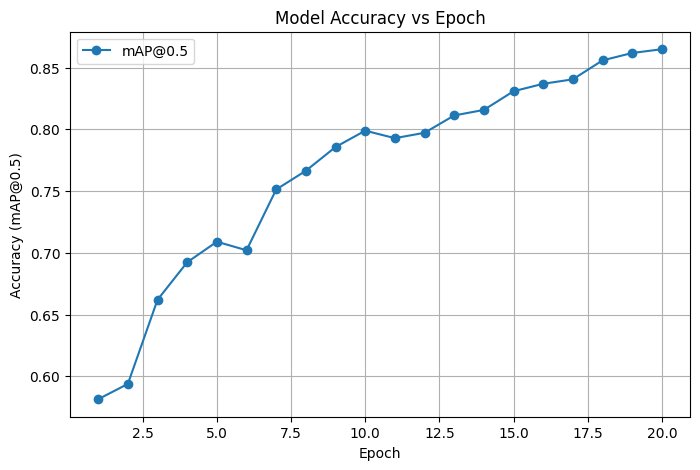

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load YOLOv8 training logs
df = pd.read_csv("/content/runs/detect/kitti_yolo_retry/results.csv")

# Plot mAP@0.5 vs epoch
plt.figure(figsize=(8, 5))
plt.plot(df['epoch'], df['metrics/mAP50(B)'], marker='o', label='mAP@0.5')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (mAP@0.5)")
plt.title("Model Accuracy vs Epoch")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
import os

model_path = "/content/runs/detect/kitti_yolo_retry/weights/best.pt"
if os.path.exists(model_path):
    print(f"The file {model_path} exists.")
else:
    print(f"The file {model_path} does not exist.")

The file /content/runs/detect/kitti_yolo_retry/weights/best.pt exists.
